In [38]:
!pip install pillow

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13931938581575715104
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 507130674
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9478680862654535603
physical_device_desc: "device: 0, name: GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras

import os
from shutil import copyfile, move
from tqdm import tqdm
import h5py
import random

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import Xception

In [4]:
dataset_df = pd.read_csv("input/train_labels.csv")
dataset_df["filename"] = [item.id+".tif" for idx, item in dataset_df.iterrows()]
dataset_df["groundtruth"] = ["cancerous" if item.label==1 else "healthy" for idx, item in dataset_df.iterrows()]
dataset_df.head()

,id,label,filename,groundtruth
0,f38a6374c348f90b587e046aac6079959adf3835,0,f38a6374c348f90b587e046aac6079959adf3835.tif,healthy
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,cancerous
2,755db6279dae599ebb4d39a9123cce439965282d,0,755db6279dae599ebb4d39a9123cce439965282d.tif,healthy
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,healthy
4,068aba587a4950175d04c680d38943fd488d6a9d,0,068aba587a4950175d04c680d38943fd488d6a9d.tif,healthy


We create the training and validation sets. The training set is composed of 80% of the dataset and the validation set contains the 20% left. It is important to have a large enough validation set as some of our training conditions (for example, early stopping) relies on the performance on the validation set.

In [5]:
training_sample_percentage = 0.8
training_sample_size = int(len(dataset_df)*training_sample_percentage)
validation_sample_size = len(dataset_df)-training_sample_size

training_df = dataset_df.sample(n=training_sample_size)
validation_df = dataset_df[~dataset_df.index.isin(training_df.index)]

# Load the dataset

In [6]:
training_batch_size = 64
validation_batch_size = 64
target_size = (96,96)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2, 
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = training_df,
    x_col='filename',
    y_col='groundtruth',
    directory='input/train/',
    target_size=target_size,
    batch_size=training_batch_size,
    shuffle=True,
    class_mode='binary')


validation_datagen = ImageDataGenerator(rescale=1. / 255)
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe = validation_df,
    x_col='filename',
    y_col='groundtruth',
    directory='input/train/',
    target_size=target_size,
    shuffle=False,
    batch_size=validation_batch_size,
    class_mode='binary')


Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [7]:
def plot_random_samples(generator):
    generator_size = len(generator)
    index=random.randint(0,generator_size-1)
    image,label = generator.__getitem__(index)

    sample_number = 10
    fig = plt.figure(figsize = (20,sample_number))
    for i in range(0,sample_number):
        ax = fig.add_subplot(2, 5, i+1)
        ax.imshow(image[i])
        if label[i]==0:
            ax.set_title("Cancerous cells")
        elif label[i]==1:
            ax.set_title("Healthy cells")
    plt.tight_layout()
    plt.show()

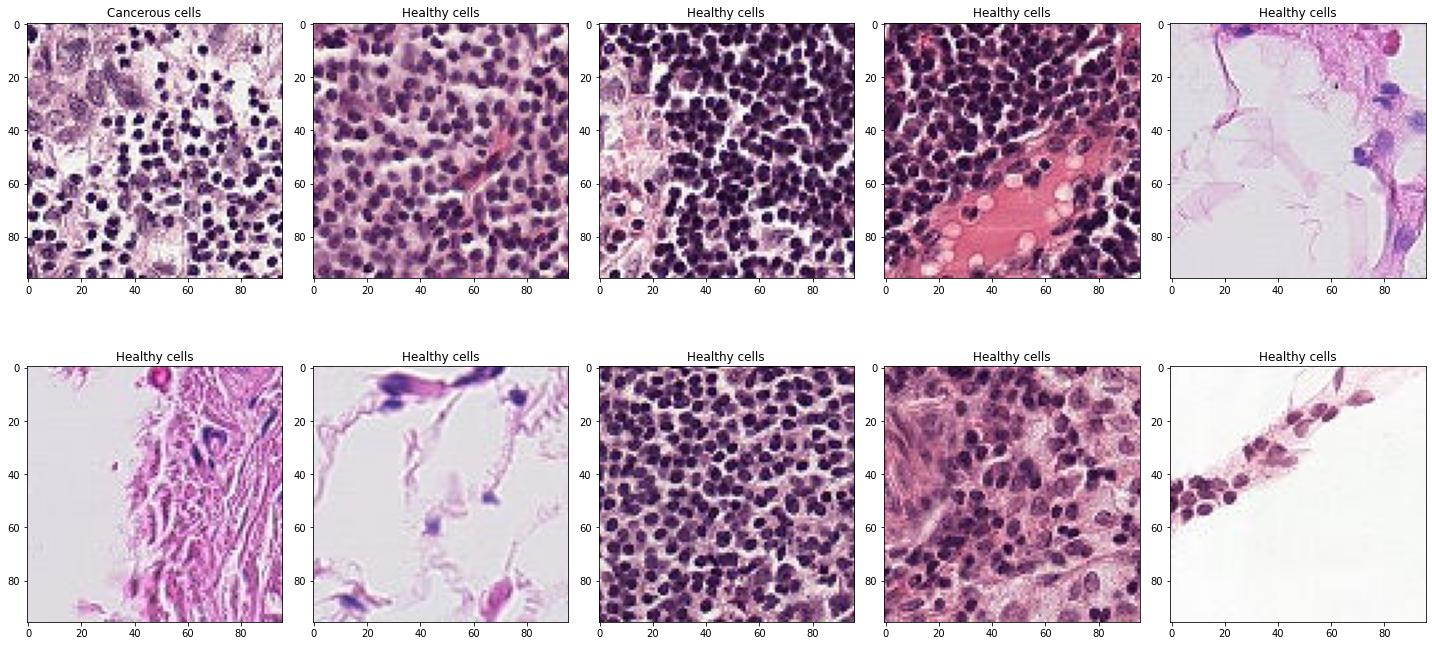

In [8]:
plot_random_samples(validation_generator)

# Create the model: Use a pretrained Xception

In [9]:
input_shape = (96, 96, 3)
pretrained_layers = Xception(weights='imagenet',include_top = False, input_shape=input_shape)
pretrained_layers.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 47, 47, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 47, 47, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 47, 47, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

We freeze all the layers except the 8 last, before checking the "trainable" status of the all the layers in our VGG16.

In [10]:
for layer in pretrained_layers.layers[:-8]:
    layer.trainable = False

for layer in pretrained_layers.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001A96B1E84E0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001A96B22D630> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x000001A96B22DF28> False
<tensorflow.python.keras.layers.core.Activation object at 0x000001A96B3D2780> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001A96B2877B8> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x000001A96B44CAC8> False
<tensorflow.python.keras.layers.core.Activation object at 0x000001A96B44CB70> False
<tensorflow.python.keras.layers.convolutional.SeparableConv2D object at 0x000001A96B4AF8D0> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x000001A96B501CC0> False
<tensorflow.python.keras.layers.core.Activation object at 0x000001A96B505080> False
<tensorflow.python.keras.layers.convolutional.SeparableConv2D object at 0x0000

We proceed to create the model by adding the pretrained VGG16 and then our bottleneck layers which will finish with a binary classification.

In [11]:
dropout_dense_layer = 0.5

model = Sequential()
model.add(pretrained_layers)
    
model.add(GlobalAveragePooling2D())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_dense_layer))

model.add(Dense(1))
model.add(Activation('sigmoid'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 3, 3, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524288    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2

In [13]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

In [14]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.5),
             EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

train_step_size = train_generator.n // train_generator.batch_size
validation_step_size = validation_generator.n // validation_generator.batch_size

In [15]:
epochs = 5
history = model.fit_generator(train_generator,
          steps_per_epoch = train_step_size,
          validation_data= validation_generator,
          validation_steps = validation_step_size,
          epochs=epochs,
          verbose=1,
          shuffle=True,
          callbacks=callbacks)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 2750 steps, validate for 687 steps
Epoch 1/5
2750/2750 [==============================] - 938s 341ms/step - loss: 0.3557 - accuracy: 0.8478 - val_loss: 0.4859 - val_accuracy: 0.7697
Epoch 2/5
2749/2750 [============================>.] - ETA: 0s - loss: 0.3093 - accuracy: 0.8706
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2750/2750 [==============================] - 934s 340ms/step - loss: 0.3093 - accuracy: 0.8705 - val_loss: 0.4978 - val_accuracy: 0.7686
Epoch 3/5
2749/2750 [============================>.] - ETA: 0s - loss: 0.2841 - accuracy: 0.8820
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
2750/2750 [==============================] - 938s 341ms/step - loss: 0.2842 - accuracy: 0.8820 - val_loss: 0.5004 - val_accuracy: 0.7616
Epoch 4/5
2749/2750 [============================>.] -

# Plotting performance during training

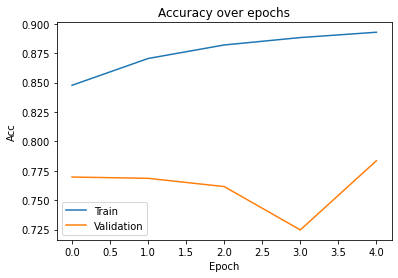

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy over epochs')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

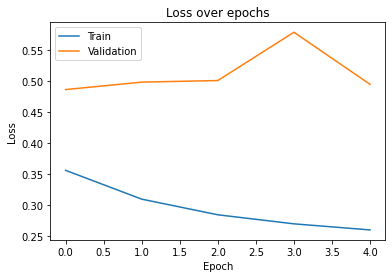

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [20]:
model.save('xception5.h5')

# Load the best model and classify images from the test set

In [ ]:
model.load_weights("best_model.h5")

In [ ]:
pred=model.predict_generator(test_generator,verbose=1)

1375/1375 [==============================] - 3419s 2s/step - loss: 0.5251  accuracy: 0.8765